<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>



<h1 align=left><font size = 6>Lab: Data Loading and Augmentation Using PyTorch</font></h1>

<h1 align=left><font size = 5.5>Building efficient data loaders with PyTorch</font></h1>


<h5>Estimated time: 60 minutes</h5>


<h2>Objective</h2>
After completing this lab, you'll be able to:

- Load the data using Pytorch data loader
- Augment the image dataset using PyTorch
- Visualize the augmented data


## Introduction

Welcome to the PyTorch version of the data loading lab! You have explored the core concept of sequential loading by manually handling file paths and opening images one by one. This memory-efficient method is the foundation for how all modern deep learning frameworks handle large datasets.

In this notebook, you will implement the **PyTorch** utilities for the same. You will discover PyTorch's modular approach, which separates *data representation* from *data iteration*:

1.  **Custom `Dataset` Class:** You'll build our own dataset class from scratch by inheriting from `torch.utils.data.Dataset`. This gives you full control and a deep understanding of the data pipeline.
2.  **In-built `ImageFolder` Utility:** You'll use the convenient `torchvision.datasets.ImageFolder` class, which automatically handles data from a standard directory structure.
3.  **The `DataLoader`:** You'll wrap both of our datasets in a `DataLoader`, PyTorch's engine for efficient batching, shuffling, and parallelized data loading.

Finally, you'll compare these methods to understand why this modular design is so powerful.


## Table of contents


<div>
<font size = 3>    

0.  [Setup](#Setup)
1.  [Custom PyTorch `Dataset`](#Custom-PyTorch-Dataset)
2.  [In-built `ImageFolder` utility](#In-built-ImageFolder-utility)
3.  [The `DataLoader` - Bringing it all together](#The-DataLoader---Bringing-it-all-together)
4.  [Comparison and analysis](#Comparison-and-analysis)

</font>
</div>


## Setup

Let's begin by importing our libraries and defining the data directories.


### Install required libraries

Some of the required libraries are __not__ pre-installed in the Skills Network Labs environment. You must run the following __cell__ to install them; it might take a few minutes for the installation.


In [10]:
%%time
%%capture captured_output
%pip install numpy==1.26 matplotlib==3.9.2 pandas==2.2.3

CPU times: user 2.83 ms, sys: 7.82 ms, total: 10.6 ms
Wall time: 956 ms


Now let's check if the above libraries are installed properly. 


In [11]:

def lib_installation_check(captured_data, n_lines_print):
    """
    A function to use the %%capture output from the cells where we try to install the libraries.
    It would print last "n_lines_print" if there is an error in library installation
    """
    output_text = captured_data.stdout
    lines = output_text.splitlines()
    output_last_n_lines = '\n'.join(lines[-n_lines_print:])
    if "error" in output_last_n_lines.lower():
        print("❌ Library installation failed!")
        print("--- Error Details ---")
        print(output_last_n_lines)
    else:
        print("✅ Library installation was successful, let's proceed ahead")    

lib_installation_check(captured_data = captured_output, n_lines_print = 5)

✅ Library installation was successful, let's proceed ahead


### `PyTorch (torch)` and `torchvision`library installation

Next, install the `PyTorch (torch)` and `torchvision` library using the code below.


In [12]:
%%time
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
ERROR: Could not find a version that satisfies the requirement torch==2.8.0+cpu (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch==2.8.0+cpu
Note: you may need to restart the kernel to use updated packages.
CPU times: user 16.9 ms, sys: 9.28 ms, total: 26.2 ms
Wall time: 1.5 s


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skillsnetwork
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

## Download data
1. Download and extract data from the cloud using `skillsnetwork.prepare` method.
2. Use a fallback method if the `skillsnetwork.prepare` command fails to download and extract the dataset.


First, set up the data extraction directory.


In [14]:
extract_dir = "."

### Data acquisition and preparation


### Define the dataset URL
We define the `url` that holds the link to the dataset. The dataset is a `.tar` archive hosted on a cloud object storage service. Cloud object storage (such as S3) is a highly scalable and durable way to store and retrieve large amounts of unstructured data.


In [15]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

### Download the data

1. Download and extract data from the cloud using `skillsnetwork.prepare` method.
2. Use a fallback method if the `skillsnetwork.prepare` command fails to download and extract the dataset. The fallback involves asynchronously downloading the `.tar` file using `httpx` and then extracting its contents using the `tarfile` library.
3. The `tarfile` module provides an interface to tar archives, supporting various compression formats such as gzip and bzip2 (handled by `r:*` mode).


In [16]:
def check_skillnetwork_extraction(extract_dir):
    """ function to check whether data download and extraction method 
    `skillsnetwork.prepare` would execute successfully, without downloading any data.
    This helps in early detection and fast fallback to explicit download and extraction
    using default libraries
    ###This is a hack for the code to run on non-cloud computing environment without errors
    """
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test) 
        print("Write permissions available for downloading and extracting the dataset tar file")
    os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """function to explicitly download and extract the dataset tar file from cloud using native python libraries
    """
    if not os.path.exists(tar_path): # download only if file not downloaded already
        try:
            print(f"Downloading from {url}...")
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)# Download the file asynchronously
                response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
            
                with open(tar_path , "wb") as f:
                    f.write(response.content) # Save the downloaded file
                print(f"Successfully downloaded '{file_name}'.")
        except httpx.HTTPStatusError as http_err:
            print(f"HTTP error occurred during download: {http_err}")
        except Exception as download_err:
            print(f"An error occurred during the fallback process: {download_err}")
    else:
        print(f"dataset tar file already downloaded at: {tar_path}")
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
    print(f"✅ Successfully extracted to '{extract_dir}'.")
            

In [17]:
try:
    check_skillnetwork_extraction(extract_dir)
    await skillsnetwork.prepare(url = url, path = extract_dir, overwrite = True)
except Exception as e:
    print(e)
    # --- FALLBACK METHOD FOR DOWNLOADING THE DATA ---
    print("❌ Primary download/extration method failed.")
    print("Falling back to manual download and extraction...")
    
    # import libraries required for downloading and extraction
    import tarfile
    import httpx 
    from pathlib import Path
    
    file_name = Path(url).name
    tar_path = os.path.join(extract_dir, file_name)
    print(f"tar_path: {os.path.exists(tar_path)} ___ {tar_path}")
    await download_tar_dataset(url, tar_path, extract_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


### Define the directories


In [18]:
# Define directories
base_dir = os.path.join(extract_dir, 'images_dataSAT')
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

## Custom PyTorch `Dataset`

In PyTorch, 
- A `Dataset` object is an iterable (gives one sample at a time).

- A `DataLoader` is an iterator that returns batches (adds a batch dimension: `[B, C, H, W]`).

- To create a custom dataset, we will create a class that inherits from `torch.utils.data.Dataset` and implements three essential methods:
- `__init__(self)`: This method is run once when the dataset is instantiated. It's where you perform initial setup, such as loading file paths and labels.
- `__len__(self)`: This returns the total number of samples in the dataset.
- `__getitem__(self, idx)`: This method is responsible for loading and returning a *single* sample from the dataset at the given index `idx`. This is the core of sequential loading; it fetches one data point from storage "just-in-time".


In [19]:
class CustomBinaryClassDataset(Dataset):
    """A custom dataset for our agricultural land classification task."""
    def __init__(self, non_agri_dir, agri_dir, transform=None):
        """
        Args:
            non_agri_dir (string): Directory with all the non-agricultural images.
            agri_dir (string): Directory with all the agricultural images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load non-agri paths and assign label 0
        for fname in os.listdir(non_agri_dir):
            self.image_paths.append(os.path.join(non_agri_dir, fname))
            self.labels.append(0)
            
        # Load agri paths and assign label 1
        for fname in os.listdir(agri_dir):
            self.image_paths.append(os.path.join(agri_dir, fname))
            self.labels.append(1)

        temp = list(zip(self.image_paths, self.labels))
        np.random.shuffle(temp)
        self.image_paths, self.labels = zip(*temp)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB") # Ensure image is in RGB format
        
        label = self.labels[idx]
        
        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Define transformations

- `torchvision.transforms` provides a suite of common image transformations. These are used for preprocessing (such as `resizing` and `converting to a tensor`) and data augmentation (such as `random flips` and `rotations`).
- `transforms.Compose` chains these operations together into a single, callable pipeline. Data augmentation is a crucial regularization technique that helps prevent overfitting by showing the model slightly different versions of the same image at each epoch.
- Transforms like `RandomFlip` and `Rotation` work on PIL images and must be applied before `ToTensor()`, which converts images to tensors.
- `Normalize()` scales tensor values (e.g., from `[0, 1]` to `[-1, 1]`) using `(x - mean) / std`  or can be based on model you are fine tuining


In [20]:
test_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(), # Converts PIL Image to a tensor and scales values to [0, 1]
                                     transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]) # Normalize to [-1, 1]
])

Now that you know how a data augmentation pipeline works in PyTorch, let’s create a transformation pipeline `custom_transform`for the given specifications. 


### **Task 1**: Create a transformation pipeline `custom_transform` for: 
    1. image size = 64 x 64 pixels
    2. RandomHorizontalFlip probability 0.5
    3. RandomVerticalFlip probability 0.2
    4. RandomRotation of 45 degrees

Then, transform it to tensor and normalize it to [-1, 1]


In [21]:
custom_transform = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.2),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1, 1]
                                      ])

Double-click **here** for the solution.
<!-- The correct answer is:

custom_transform = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.2),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1, 1]
                                      ])

-->


## In-built `ImageFolder` utility

For datasets that follow a standard `root/class_name/xxx.ext` directory structure, PyTorch provides `torchvision.datasets.ImageFolder`. This is a specialized `Dataset` class that does all the work of finding image paths and inferring class labels for you. It's the most convenient way to load image datasets organized in folders, where each subfolder represents a different class.

**ImageFolder** acts as a quick bridge between raw image files and PyTorch models. You can point the `root` argument at the top-level dataset folder, and the class automatically walks through every subfolder, using each subfolder’s name as a label. You can attach a `transform pipeline` with common choices including `transforms.Resize`, `transforms.CenterCrop`, `transforms.ToTensor`, and `transforms.Normalize` to pre-process every image on the fly. Calling `len(dataset)` reveals total images, while indexing `dataset[i]` returns an `(image, label)` pair. You can then combine it with `DataLoader` to batch, shuffle, and parallel-load data effortlessly.

**ImageFolder** works on the `dataset folder` structured as represented below:

    dataset/
    ├── class1/
    │   ├── image1.jpg
    │   └── image2.jpg
    └── class2/
        ├── image3.jpg
        └── image4.jpg
    

From this dataset, you can create a `dataset object` like this: 

```
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(
    root='path/to/dataset',
    transform=transform

```

Then, you can use this `dataset object` to create a `dataloader` like this:
```
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    # Your training code here
    .
    .
    ...

```
This `dataloader` can then be used for creating batches of images for training / testing of the model.

**`ImageFolder`** automatically assigns numerical labels to classes based on folder names alphabetically. Access class names via `dataset.classes` and class-to-index mapping via `dataset.class_to_idx`


Your task is to get the dataset and apply custom_transform.


### **Task 2**: Get the dataset **imagefolder_dataset** using `datasets.Imagefolder` method and applying **custom_transform**


In [22]:
imagefolder_dataset = datasets.ImageFolder(root=base_dir, transform=custom_transform)



Double-click **here** for the solution.
<!-- The correct answer is:
imagefolder_dataset = datasets.ImageFolder(root=base_dir, transform=custom_transform)
-->


Next, print the name and the class index. 


### **Task 3**: Print the name and the class index from the **imagefolder_dataset**


In [23]:
print(f"Classes found by ImageFolder: {imagefolder_dataset.classes}")
print(f"Class to index mapping: {imagefolder_dataset.class_to_idx}")



Classes found by ImageFolder: ['class_0_non_agri', 'class_1_agri']
Class to index mapping: {'class_0_non_agri': 0, 'class_1_agri': 1}


Double-click **here** for the solution.
<!-- The correct answer is:
print(f"Classes found by ImageFolder: {imagefolder_dataset.classes}")
print(f"Class to index mapping: {imagefolder_dataset.class_to_idx}")
-->


## The `DataLoader` - Bringing it all together

The `DataLoader` is an iterator that returns batches, based on the `batch_size`. It wraps a `Dataset` object and provides an iterable to access the data. Its key responsibilities are:
- **Batching:** This involves grouping individual samples into mini-batches.
- **Shuffling:** This involves randomly shuffling the data every epoch to prevent the model from learning the order of samples. The data loading process is parallelized, preventing the CPU from becoming a bottleneck for the GPU.

We can use the `DataLoader` with **both** our `CustomBinaryClassDataset` and the `ImageFolder` dataset.

Linear and convolution layers in a neural network can work **with or without** the batch dimension 
- e.g., with shapes `[C, H, W]` or  `[B, C, H, W]`, where:
    - `B`: `batch_size`
    - `C`: `number of channels`
    - `H`: `image height`
    - `W`: `image width`


In [24]:
BATCH_SIZE = 8 #  the number of images in a batch (batch size)

# --- Using your Custom Dataset ---
custom_dataset = CustomBinaryClassDataset(dir_non_agri, dir_agri, transform=custom_transform)
custom_loader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# --- Using the ImageFolder Dataset ---
imagefolder_loader = DataLoader(imagefolder_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("DataLoaders created successfully!")

DataLoaders created successfully!


### Visualize a batch

Let's inspect a batch from our `DataLoader`. You can use `iter()` and `next()` to pull a single batch. This is exactly what a training loop does under the hood. Visualizing the images and their labels confirms that our entire pipeline (from path loading and transformation to batching) is working correctly.


In [26]:

images_custom, labels_custom = next(iter(custom_loader))

print(f"Images batch shape (Custom loader): {images_custom.shape}") 
print(f"Labels batch shape (Custom loader): {labels_custom.shape}")


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'CustomBinaryClassDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

Your next task is to get the images and labels from the loader. 


### **Task 4**: Get a batch of images and labels from the `imagefolder_loader` and print their shape 


In [27]:
images_inbuilt, labels_inbuilt = next(iter(imagefolder_loader))

print(f"Images batch shape (PyTorch in-built loader): {images_inbuilt.shape}") 
print(f"Labels batch shape (PyTorch in-built loader): {labels_inbuilt.shape}")

Images batch shape (PyTorch in-built loader): torch.Size([8, 3, 64, 64])
Labels batch shape (PyTorch in-built loader): torch.Size([8])


Next, define a function to display an image from the batch. 


In [28]:
def imshow(img):
    """Helper function to un-normalize and display an image"""
    img = img / 2 + 0.5  # Un-normalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Convert from C,H,W to H,W,C

Then, display the images in the PyTorch in-built loader batch.


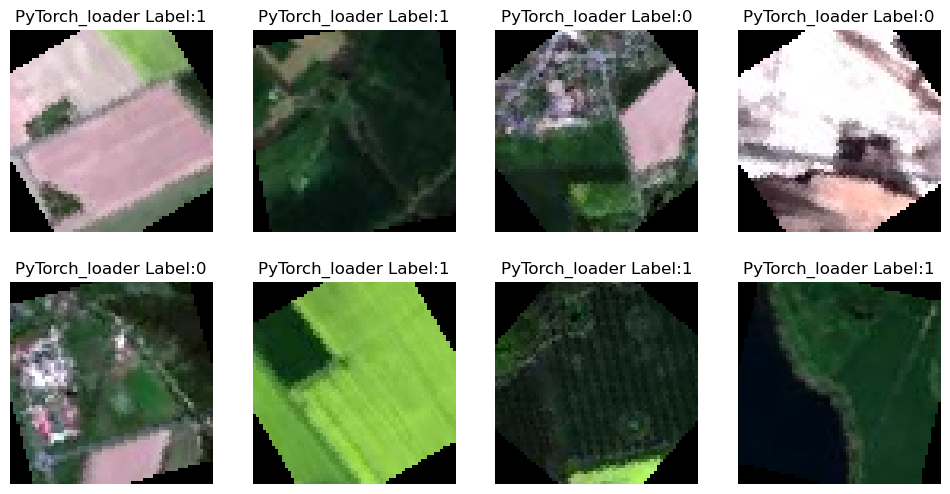

In [29]:
plt.figure(figsize = (12, 6))
for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images_inbuilt[i])
    plt.title(f"PyTorch_loader Label:{labels_inbuilt[i].item()}")
    plt.axis("off")    

### **Task 5**: Display the images in the Custom loader batch
Similar to the code cell above, display the images stored in `images_custom` generated using `custom_loader`. 

The title of the images should be **`Custom_loader Label: `** similar to the images seen in the above cell


NameError: name 'images_custom' is not defined

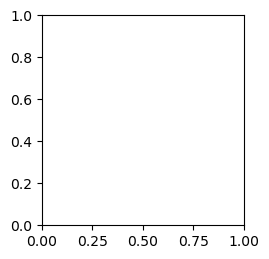

In [31]:
plt.figure(figsize=(12, 6))
for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images_custom[i])
    plt.title(f"Custom_loader Label:{labels_custom[i].item()}")
    plt.axis("off")

Double-click **here** for the solution.
<!-- The correct answer is:
plt.figure(figsize=(12, 6))
for i in range(BATCH_SIZE):
    ax = plt.subplot(2, 4, i + 1)
    imshow(images_custom[i])
    plt.title(f"Custom_loader Label:{labels_custom[i].item()}")
    plt.axis("off")
-->


## Comparison and analysis

In PyTorch, both methods lead to a `DataLoader`. The key difference lies in how the underlying `Dataset` is created.


| Feature                  | Custom `Dataset`                                       | In-built `ImageFolder`     |
|--------------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| **Ease of use**          | Low. It requires writing a custom class with three specific methods. | High. It requires only a single, intuitive class instantiation. |
| **Code complexity**      | High. You manually manage file paths, labels, and the loading logic inside `__getitem__`. | Low. The class handles all path and label discovery automatically.          |
| **Flexibility**          | Very high. It is essential for non-standard directory structures, loading labels from a CSV/JSON, or complex loading logic (for example, from a database). | Moderate. It strictly requires the `root/class/image.ext` directory structure. |
| **Performance**          | Potentially high. Performance depends on the efficiency of your `__getitem__` method. When wrapped in a `DataLoader` with `num_workers`, it can be highly performant. | High. `ImageFolder` is optimized and, when wrapped in a `DataLoader`, provides excellent performance out-of-the-box. |
| **Recommended for**      | It is recommended for complex, non-standard datasets or when you need fine-grained control over every aspect of data loading. | It is recommended for almost all standard image classification tasks.        |


## Conclusion

This lab has demonstrated the power and elegance of PyTorch's data loading API. The key takeaway is the **separation of concerns**:
- The `Dataset` class defines *what* the data is and *how to get a single item*.
- The `DataLoader` class defines *how to iterate over* the data, handling batching, shuffling, and performance optimization.

While building a custom `Dataset` is an excellent way to understand the underlying mechanics and is necessary for complex scenarios, `ImageFolder` provides a simple and robust solution for the vast majority of image classification problems. In either case, the `DataLoader` is the essential tool that makes the entire pipeline efficient and ready for training a deep learning model.

You are now equipped with standard, production-ready methods for loading image data in PyTorch!


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.





<!--
## Change Log

'''|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
```
```|---|---|---|---|
```
```| 2025-06-21  | 1.0  | Aman  |  Created the lab |
```
```| 2025-06-28  | 2.0  | Sangeeta |  ID review |
```
-->


© Copyright IBM Corporation. All rights reserved.
